### Introduction to Operator Learning in TorchPhysics

This notebook contains a template for the joint exercise regarding operator learning utilities of TorchPhysics.

We start easy and try to learn the integral operator given by the ODE
\begin{align*}
    \partial_t u(t) &= 5.0f(t) \quad \text{ in } (0, 1), \\
    u(0) &= 0.
\end{align*}
Goal is to train one network that outpus $u$ for a given $f$. 

We will use the Deep Operator Networks (DeepONet) [(paper)](https://arxiv.org/abs/2103.10974) to solve this problem.

In [ ]:
# This block is for GPU selection. Please execute.
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

Given that DeepONets are a data-driven approach we first have to load some data.

In [13]:
save_path = "/localdata/tomfre/DeepONet_data_integrator"
input_t = torch.load(f"{save_path}/input_t.pt")
input_f = torch.load(f"{save_path}/input_f.pt")
output_u = torch.load(f"{save_path}/output_u.pt")

print("Time discretization:", len(input_t))
print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

Time discretization: 100
Available data points: 20000
Shape of data: torch.Size([20000, 100, 1])


Next, we can have a look at one example of our data set.

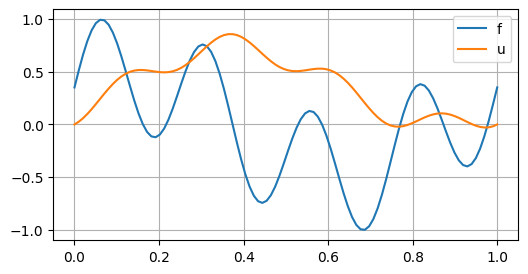

In [ ]:
example_idx = 102
plt.figure(0, figsize=(6, 3))
plt.plot(input_t, input_f[example_idx])
plt.plot(input_t, output_u[example_idx])
plt.grid()
leg = plt.legend(["f", "u"])

Next we implement the *Spaces* that appear in the problem. Now we have additional *FunctionSpaces* defining what kind of functions appear in the problem.

In [ ]:
T = ...
F = ...
U = ...

fn_space_F = ...
fn_space_U = tp.spaces.FunctionSpace(T, U)

We split our data into training and testing set. Such that we only train on one part of the data and afterwards can validate our model on the unseen testing set.

In [ ]:
# Split data into training and testing:
total_data = len(input_f)
train_N = int(0.8*total_data) # we use 80% of the data for training

train_f = ...
train_u = ...

test_f = ...
test_u = ...

# Define FunctionSet (similar to a PyTorch DataSet) to handle data collection.
data_functionset_input = tp.domains.DataFunctionSet(...)
data_functionset_output = tp.domains.DataFunctionSet(...)

We marked what data belongs to what space, now we also create an object that selects some samples from our data and passes it to our model for training.
This is done by the *FunctionSampler*-class. They are comparable to the *Samplers* from before.

In [ ]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(...)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(...)

Now we define our neural network that should learn the operator. As explained the DeepONet consists of two different parts, the *TrunkNet* and the *BranchNet*. They are created separately, one could just for them abritrary architectures. 

In [ ]:
### DeepONet
trunk_net = tp.models.FCTrunkNet(..., hidden=(30, 30, 30))
branch_net = tp.models.FCBranchNet(..., hidden=(50, 50, 50))
model = tp.models.DeepONet(...)

For the training we again need to define a condition that defines what model should learn what kind of equation. Since we are only working with a data-driven learning objective, this is quite simple here.
The *OperatorCondition* will plug the data $X_i$ provided from one sampler into the model and compares the output $u_\theta(X_i)$ with the data $Y_i$ of the second sampler by computing the mean squarred error:
\begin{align*}
    \frac{1}{N}\sum_{i=1}^N \|u_\theta(X_i) - Y_i\|^2
\end{align*}

In [ ]:
data_condition = tp.conditions.OperatorCondition(module=..., 
                                                 input_function_sampler=..., 
                                                 output_function_sampler=...)

Start the training. Where we now also add a *learning rate scheduler* to decrease the learning rate after a given number of steps.

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.005,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 3000, "gamma":0.25})

# As before define the solver and trainer:
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=20000, 
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 16.2 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
16.2 K    Trainable params
0         Non-trainable params
16.2 K    Total params
0.065     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 20000/20000 [02:11<00:00, 152.58it/s, train/loss=0.000526]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|██████████| 20000/20000 [02:11<00:00, 152.57it/s, train/loss=0.000526]


Finally, we check the performance on the test data (which the model has not seen before!).

In [23]:
model_output = model(branch_inputs=tp.spaces.Points(test_f, F)).as_tensor.detach()
rel_error = torch.max(torch.abs(model_output - test_u)) / torch.max(torch.abs(test_u))
print(f"Relative error on test data: {rel_error*100} %")

Relative error on test data: 5.343601703643799 %


We can also visualize the performance:

Example plot:


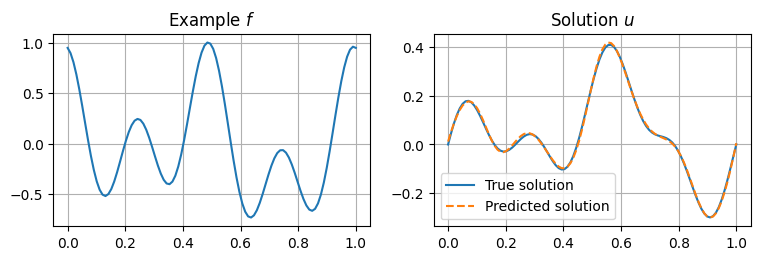

In [ ]:
print("Example plot:")
plot_idx = 620
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(input_t, test_f[plot_idx])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(input_t, test_u[plot_idx])
axarr[1].plot(input_t, model_output[plot_idx], linestyle="--")
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
leg = axarr[1].legend(["True solution", "Predicted solution"])